In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import math
#%matplotlib inline

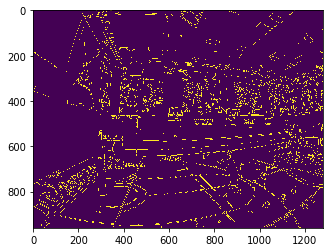

In [2]:
image = cv2.imread('/Users/scoot/Documents/GitHub/VB-Research/Scott-Notes/Sample5-1_Moment.jpg',1)
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
# gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
edges = cv2.Canny(gray,100,200,apertureSize=3)
plt.imshow(edges)

In [3]:
lines = cv2.HoughLines(edges,1,np.pi/180,200)
# print(lines[0])

In [4]:
equations = []
for i in range(len(lines)):
    for rho,theta in lines[i]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
        x = [x1,x2]
        y = [y1,y2]
        print("x:", x)
        print("y:", y)
        if (x2-x1) == 0:
            break
        slope = float((y2-y1))/float((x2-x1))
        print("slope: ", slope)
        intercept = y1 - (slope*x1)
        print("intercept:", intercept)
        equations.append((slope,intercept))
#         coeff = np.polyfit(x,y,1)
#         poly = np.poly1d(coeff)
        cv2.line(image,(x1,y1),(x2,y2),(0,0,255),2)
cv2.imwrite('detectedLines.jpg',image)
print("num of lines:", len(equations))

('x:', [-1000, 999])
('y:', [957, 958])
('slope: ', 0.0005002501250625312)
('intercept:', 957.5002501250625)
('x:', [-1000, 999])
('y:', [0, 1])
('slope: ', 0.0005002501250625312)
('intercept:', 0.5002501250625312)
('x:', [1, 1])
('y:', [1000, -1000])
('x:', [1278, 1278])
('y:', [1000, -1000])
('x:', [-288, 1243])
('y:', [1211, -73])
('slope: ', -0.8386675375571522)
('intercept:', 969.4637491835401)
('x:', [-1000, 999])
('y:', [461, 462])
('slope: ', 0.0005002501250625312)
('intercept:', 461.5002501250625)
('x:', [-888, 1092])
('y:', [865, 586])
('slope: ', -0.1409090909090909)
('intercept:', 739.8727272727273)
('x:', [-1000, 999])
('y:', [463, 464])
('slope: ', 0.0005002501250625312)
('intercept:', 463.5002501250625)
('x:', [-943, 1051])
('y:', [844, 705])
('slope: ', -0.06970912738214644)
('intercept:', 778.264292878636)
('x:', [-870, 1104])
('y:', [896, 583])
('slope: ', -0.1585612968591692)
('intercept:', 758.0516717325228)
('x:', [-870, 1105])
('y:', [898, 585])
('slope: ', -0.158

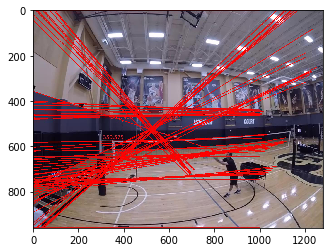

In [5]:
im2 = cv2.imread('detectedLines.jpg',1)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)
plt.imshow(im2)

In [17]:
intersectionPoints = []
for i in range(len(equations)):
    for j in range(i+1,len(equations)):
        e1slope = equations[i][0]
        e1inter = equations[i][1]
        e2slope = equations[j][0]
        e2inter = equations[j][1]
        if((e2slope - e1slope) == 0):
            break
        xint = (e1inter - e2inter) / (e2slope - e1slope)
        yint = (e1slope * xint) + e1inter
        print("x:",xint)
        print("y:",yint)
        intersectionPoints.append([xint,yint])

('x:', 1154.6719419900032)
('y:', 1.077874908449226)
('x:', 605.3181574825163)
('y:', 461.8030606090457)
('x:', 329.0408349963194)
('y:', 693.5078823414277)
('x:', 602.9348438837853)
('y:', 463.8018683561199)
('x:', 248.6473309543353)
('y:', 760.9313044119094)
('x:', 310.8515475965171)
('y:', 708.7626472149393)
('x:', 307.7717986655301)
('y:', 711.3455326671844)
('x:', 456.0368830446948)
('y:', 587.000419445207)
('x:', 1088.392872027016)
('y:', 56.66397930588596)
('x:', 501.93253546541985)
('y:', 548.5092256449385)
('x:', 374.99025301412297)
('y:', 654.9715970802522)
('x:', 255.52622716121536)
('y:', 755.1621974689741)
('x:', 344.6868184459557)
('y:', 680.3861039290613)
('x:', 386.56717144063566)
('y:', 645.2624114109888)
('x:', 326.0963575631052)
('y:', 695.9773199797341)
('x:', 530.9247816005878)
('y:', 524.1943699705064)
('x:', 526.024911117134)
('y:', 528.3037322832135)
('x:', 635.1095774666534)
('y:', 436.8179637706186)
('x:', 600.1457146483808)
('y:', 466.1410205039053)
('x:', 47

('y:', 517.3764358003792)
('x:', 531.3963191105958)
('y:', 527.5115554681757)
('x:', 630.0917404947518)
('y:', 641.0376389520105)
('x:', 524.2943043486374)
('y:', 519.3423424544205)
('x:', 476.9515884350257)
('y:', 464.8855799847588)
('x:', 604.0744490855934)
('y:', 611.1108079489511)
('x:', 484.04568527918747)
('y:', 473.0456852791874)
('x:', 586.4300267070092)
('y:', 590.815011650778)
('x:', 572.9451197703457)
('y:', 575.3037685840438)
('x:', 648.2230497212009)
('y:', 661.8934851102754)
('x:', 710.917973309238)
('y:', 734.0093850116941)
('x:', 461.1464185053798)
('y:', 446.70541503135985)
('x:', 526.0346042079975)
('y:', 521.3441519036311)
('x:', 527.7590520829591)
('y:', 523.3277273387508)
('x:', 572.0605397562057)
('y:', 574.2862654098842)
('x:', 563.7720056889175)
('y:', 564.7522384278319)
('x:', 704.476934130358)
('y:', 726.6004703803051)
('x:', 604.640625)
('y:', 611.7620614035088)
('x:', 464.44889826926226)
('y:', 450.5041484287167)
('x:', 574.8653656715077)
('y:', 577.51256402

In [37]:
print(len(intersectionPoints))
print(len(equations))
dfIP = pd.DataFrame(intersectionPoints,columns=['x','y'])
print(dfIP)

1683
69
                 x           y
0      1154.671942    1.077875
1       605.318157  461.803061
2       329.040835  693.507882
3       602.934844  463.801868
4       248.647331  760.931304
5       310.851548  708.762647
6       307.771799  711.345533
7       456.036883  587.000419
8      1088.392872   56.663979
9       501.932535  548.509226
10      374.990253  654.971597
11      255.526227  755.162197
12      344.686818  680.386104
13      386.567171  645.262411
14      326.096358  695.977320
15      530.924782  524.194370
16      526.024911  528.303732
17      635.109577  436.817964
18      600.145715  466.141021
19      471.017196  574.436918
20      340.431366  683.955013
21      644.353441  429.065436
22      529.529667  525.364407
23      534.099912  521.531491
24      132.571872  858.280024
25      503.877798  546.877798
26      539.194166  517.259105
27      229.351690  777.113932
28      381.805051  649.256247
29      827.164691  275.747575
...            ...         ...


                x           y
0     1154.671942    1.077875
1      605.318157  461.803061
2      329.040835  693.507882
3      602.934844  463.801868
4      248.647331  760.931304
5      310.851548  708.762647
6      307.771799  711.345533
7      456.036883  587.000419
8     1088.392872   56.663979
9      501.932535  548.509226
10     374.990253  654.971597
11     255.526227  755.162197
12     344.686818  680.386104
13     386.567171  645.262411
14     326.096358  695.977320
15     530.924782  524.194370
16     526.024911  528.303732
17     635.109577  436.817964
18     600.145715  466.141021
19     471.017196  574.436918
20     340.431366  683.955013
21     644.353441  429.065436
22     529.529667  525.364407
23     534.099912  521.531491
24     132.571872  858.280024
25     503.877798  546.877798
26     539.194166  517.259105
27     229.351690  777.113932
28     381.805051  649.256247
29     827.164691  275.747575
...           ...         ...
1652   638.378126  645.819599
1653   647

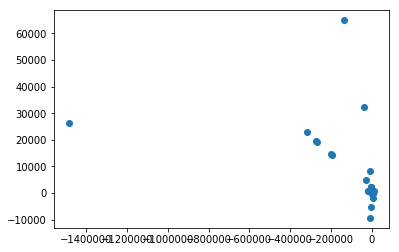

In [43]:
# dfIP = dfIP.loc[dfIP['x'] <10000]
dfIP[dfIP.x <= 10000]
print(dfIP)
plt.scatter(dfIP.x,dfIP.y)
plt.show()